### Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов
Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Описание данных
#### Таблица users (информация о пользователях):

#### user_id — уникальный идентификатор пользователя
first_name — имя пользователя
last_name — фамилия пользователя
age — возраст пользователя (годы)
reg_date — дата подключения тарифа (день, месяц, год)
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
city — город проживания пользователя
tariff — название тарифного плана
Таблица calls (информация о звонках):
id — уникальный номер звонка
call_date — дата звонка
duration — длительность звонка в минутах
user_id — идентификатор пользователя, сделавшего звонок
Таблица messages (информация о сообщениях):
id — уникальный номер сообщения
message_date — дата сообщения
user_id — идентификатор пользователя, отправившего сообщение
Таблица internet (информация об интернет-сессиях):
id — уникальный номер сессии
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
session_date — дата интернет-сессии
user_id — идентификатор пользователя
Таблица tariffs (информация о тарифах):
tariff_name — название тарифа
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)
Примечание. Если объединение таблиц методом merge приводит к ошибке dead kernell, примените метод join — это облегчит нагрузку на Jupyter Notebook.

привет, Александр) Спасибо за замечание, я учту в будущем)

Для начала импортируем нужные нам библиотеки 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st

## Обработка данных

загружаем данные

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### 1.1 Обработка жанных
Начнем смотреть общую информацию по файлам, начнем с call

In [3]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


значения 0, может быть пропущенным или отклоненным вызовом, давайте посмотрим сколько этих значений 

In [5]:
calls[calls['duration']==0]['duration'].value_counts().sum()

39613

Предлагаю удалить эти нули, т.к. к исследованию они не имеют отношения

In [6]:
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()

In [7]:
calls.describe()

,duration,user_id
count,162994.000000,162994.000000
mean,8.397794,1254.149877
std,5.353022,144.751050
min,0.010000,1000.000000
25%,4.170000,1126.000000
50%,7.740000,1261.000000
75%,11.850000,1379.000000
max,38.000000,1499.000000


видим что есть звонки с дробным значением, их придется округлить в большую сторону, по условиям "Мегалайн"

In [8]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')


In [9]:
calls.sample(5)

,id,call_date,duration,user_id
102468,1263_345,2018-12-31,3,1263
28711,1072_37,2018-08-23,1,1072
156197,1385_276,2018-04-21,11,1385
70756,1176_536,2018-10-09,17,1176
100474,1256_127,2018-11-15,20,1256


создадим столбец месяцев для дальнейших расчетов

In [10]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month


In [11]:
calls.head()

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9


#### Рассмотрим файл internet

In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Данные в порядке

приведем даты к соответствующему типу данных

In [13]:
internet['id'] = internet['id'].astype('int')

In [14]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

также добавим столбец месяцев для дальнейших расчетов

In [15]:
internet['month'] = internet['session_date'].dt.month

In [16]:
internet.describe()

,Unnamed: 0,id,mb_used,user_id,month
count,149396.000000,1.493960e+05,149396.000000,149396.000000,149396.000000
mean,74697.500000,8.968475e+05,370.192426,1252.099842,8.563315
std,43127.054745,5.419758e+05,278.300951,144.050823,2.788717
min,0.000000,1.000000e+04,0.000000,1000.000000,1.000000
25%,37348.750000,1.389878e+05,138.187500,1130.000000,7.000000
50%,74697.500000,1.145212e+06,348.015000,1251.000000,9.000000
75%,112046.250000,1.321559e+06,559.552500,1380.000000,11.000000
max,149395.000000,1.499156e+06,1724.830000,1499.000000,12.000000


In [17]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

Да, нулевые значения действительно есть, но Unhamed - уникальный номер сессии и mb_used означает что интернетом не пользовались, думаю можно оставить без изменений

#### Messages

In [18]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Данные в порядке

Также приведем даты в соответсвующий тип данных

In [19]:
messages['id'] = messages['id'].astype('int')

In [20]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

создадим столбец месяцев

In [21]:
messages['month'] = messages['message_date'].dt.month

#### Users

In [22]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Все в порядке, пропущенные значения в churn_date означают что тариф еще действовал на момент записи данных

Приведем даты в соответствующий тип данных

In [23]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

### Tariff 
на всякий случай проверим, файл должен содержать информацию о тарифах

In [24]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [25]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

In [26]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### 1.2 количество сделанных звонков и израсходованных минут разговора по месяцам

In [27]:
user_calls = calls.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'duration':'month_calls_duration','id':'calls_total_in_month'})\

In [28]:
user_calls.head()

,user_id,month,month_calls_duration,calls_total_in_month
0,1000,5,159,17
1,1000,6,172,28
2,1000,7,340,41
3,1000,8,408,42
4,1000,9,466,46


Посчитали звонки и переименовали столбцы

### 1.3 количество отправленных сообщений по месяцам

In [29]:
user_messages = messages.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id':'sms_total_in_month'})

In [30]:
user_messages.head()

,user_id,month,sms_total_in_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Посчитали смс и переименовали столбцы

### 1.4 объем израсходованного интернет-трафика по месяцам

In [31]:
user_internet = internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns={'mb_used':'mb_total_in_month'})

In [32]:
user_internet.head()

,user_id,month,mb_total_in_month
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0


те же манипуляции что и со звонками и смс

### 1.5 помесячная выручка с каждого пользователя

Склеим таблицы звонков, смс и интернета

In [33]:
df = user_calls.merge(user_messages, on=['user_id','month'], how='outer')

In [34]:
df = df.merge(user_internet, on=['user_id','month'], how = 'outer')

In [35]:
df.sample(5)

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month
884,1144,4,32.0,3.0,3.0,690.0
2810,1440,11,169.0,19.0,97.0,17734.0
2982,1469,11,795.0,88.0,NaN,35533.0
2343,1375,12,858.0,95.0,75.0,21563.0
2527,1400,11,511.0,65.0,63.0,26144.0


In [36]:
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month
0,1000,5,159.0,17.0,22.0,2256.0
1,1000,6,172.0,28.0,60.0,23257.0
2,1000,7,340.0,41.0,75.0,14016.0
3,1000,8,408.0,42.0,81.0,14070.0
4,1000,9,466.0,46.0,57.0,14581.0


In [37]:
df = df.merge(users, on='user_id', how='left')
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,159.0,17.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,172.0,28.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,340.0,41.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,408.0,42.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,466.0,46.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [38]:
df = df.merge(tariffs, on='tariff', how='left')

присоединили все что нам понадобится, давайте проверим на предмет нулей и дубликатов полученный датафрейм

In [39]:
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,17.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,28.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,41.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,42.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,46.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Да, действительно, все верно, давайте воспользуемся ранее использованным методом ceil

In [40]:
df.duplicated().sum()

0

In [41]:
df.isna().sum()

user_id                     0
month                       0
month_calls_duration       46
calls_total_in_month       46
sms_total_in_month        497
mb_total_in_month          11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

заменим на нули пропущенные значения, не будем трогать churn_date

In [42]:
df['sms_total_in_month'] = df['sms_total_in_month'].fillna(0)
df['mb_total_in_month'] = df['mb_total_in_month'].fillna(0)
df['month_calls_duration'] = df['month_calls_duration'].fillna(0)
df['calls_total_in_month'] = df['calls_total_in_month'].fillna(0)

In [43]:
df.isna().sum()

user_id                     0
month                       0
month_calls_duration        0
calls_total_in_month        0
sms_total_in_month          0
mb_total_in_month           0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

### Подготовка данных

воспользуемся формулой (бесплатный лимит - потраченный)*цена (гб, смс, звонков) и добавим столбцы

In [44]:
df['calls_paid'] = ((df['month_calls_duration'] - df['minutes_included']) * df['rub_per_minute'])
df['messages_paid'] = ((df['sms_total_in_month'] - df['messages_included']) * df['rub_per_message'])
df['mg_paid'] = ((df['mb_total_in_month'] - df['mb_per_month_included']) * df['rub_per_gb']/1024)

In [45]:
df.sample(5)

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_paid,messages_paid,mg_paid
2374,1378,12,563.0,72.0,7.0,13756.0,21,NaT,Иркутск,Евгения,...,50,15360,500,550,200,3,3,189.0,-129.0,-313.281250
2867,1453,11,973.0,100.0,57.0,24069.0,50,NaT,Москва,Кузьма,...,1000,30720,3000,1950,150,1,1,-2027.0,-943.0,-974.267578
1196,1188,8,34.0,3.0,7.0,10315.0,41,NaT,Санкт-Петербург,Габриэль,...,50,15360,500,550,200,3,3,-1398.0,-129.0,-985.351562
2000,1320,12,429.0,50.0,16.0,14122.0,38,NaT,Балашиха,Рубен,...,50,15360,500,550,200,3,3,-213.0,-102.0,-241.796875
933,1150,8,372.0,35.0,116.0,14823.0,58,NaT,Сургут,Майя,...,1000,30720,3000,1950,150,1,1,-2628.0,-884.0,-2328.662109


ожидаемо появились отрицательные значения - их нельзя менять на положительные числа, ведь отрицательные значения означают что пользователь не вышел за пределы тарифа, т.ч. давайте изменим их на 0

In [46]:
df['messages_paid'] = df['messages_paid'].clip(lower = 0)
df['calls_paid'] = df['calls_paid'].clip(lower = 0)
df['mg_paid'] = df['mg_paid'].clip(lower = 0)


In [47]:
df.sample(5)

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_paid,messages_paid,mg_paid
2861,1453,5,929.0,94.0,54.0,29704.0,50,NaT,Москва,Кузьма,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.000000
1466,1233,12,671.0,72.0,27.0,20342.0,28,NaT,Воронеж,Сара,...,50,15360,500,550,200,3,3,513.0,0.0,973.046875
2542,1402,4,733.0,84.0,21.0,24644.0,23,NaT,Пенза,Мариетта,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.000000
2554,1403,8,125.0,13.0,48.0,28924.0,18,NaT,Брянск,Ахмет,...,1000,30720,3000,1950,150,1,1,0.0,0.0,0.000000
2366,1378,4,572.0,64.0,17.0,10840.0,21,NaT,Иркутск,Евгения,...,50,15360,500,550,200,3,3,216.0,0.0,0.000000


приведем к целым значениям

In [48]:
df['calls_paid'] = df['calls_paid'].astype('int')
df['messages_paid'] = df['messages_paid'].astype('int')
df['mg_paid'] = df['mg_paid'].astype('int')

добавим новый столбец profit где присутствуют все траты пользователя

In [49]:
df['profit'] = df['rub_monthly_fee'] + df['calls_paid'] + df['messages_paid'] + df['mg_paid']


In [50]:
df.head(10)

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,...,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_paid,messages_paid,mg_paid,profit
0,1000,5,159.0,17.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950
1,1000,6,172.0,28.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950
2,1000,7,340.0,41.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950
3,1000,8,408.0,42.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950
4,1000,9,466.0,46.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950
5,1000,10,350.0,44.0,73.0,14717.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950
6,1000,11,338.0,37.0,58.0,14768.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950
7,1000,12,333.0,38.0,70.0,9827.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950
8,1001,11,430.0,45.0,0.0,18452.0,41,NaT,Москва,Иван,...,15360,500,550,200,3,3,0,0,603,1153
9,1001,12,414.0,47.0,0.0,14053.0,41,NaT,Москва,Иван,...,15360,500,550,200,3,3,0,0,0,550


Сохраним общую прибыль с каждого тарифа отдельно по звонкам,сообщениям,интернету и общую стоимость.

In [51]:
total_profit = df.pivot_table(index = ['tariff'], values = ['calls_paid', 'messages_paid', 'mg_paid', 'profit'], aggfunc=['sum'])

In [52]:
total_profit

sum                                
       calls_paid messages_paid  mg_paid   profit
tariff                                           
smart      278217         38784  1205535  2748486
ultra           0             0   108806  2029556

как видим что пока смарт лидирует по дополнительным тратам 

создадим переменные для дальнейших подсчетов

In [53]:
sum_smart = df[(df['tariff'] == 'smart')]

In [54]:
sum_ultra = df[(df['tariff'] == 'ultra')]

### 3. Анализ данных
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [55]:
df['profit'].describe()

count    3214.000000
mean     1486.634101
std       783.896681
min       550.000000
25%       694.000000
50%      1562.500000
75%      1950.000000
max      6711.000000
Name: profit, dtype: float64

на первый взгляд все нормально, 

построим гистограммы тарифов 

Text(0, 0.5, 'тарифные опции')

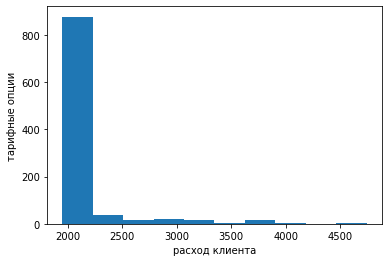

In [56]:
ultra_common = df[df['tariff'] == 'ultra']['profit'].plot(kind='hist', bins=10)
ultra_common.set_xlabel("расход клиента")
ultra_common.set_ylabel("тарифные опции")

Text(0, 0.5, 'тарифные опции')

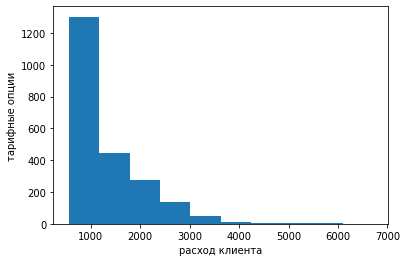

In [57]:
smart_common = df[df['tariff'] == 'smart']['profit'].plot(kind='hist', bins=10)
smart_common.set_xlabel("расход клиента")
smart_common.set_ylabel("тарифные опции")

видно что в ультре пользователи не часто выходят из-за пределов тарифного плана, в смарте видим обратную ситуацию

посмотрим на среднее, дисперсию и стандартное отклонение 

In [58]:
df.groupby('tariff')\
  .agg({'profit':['median','mean','var','std']})

profit                                        
       median         mean            var         std
tariff                                               
smart     959  1233.057873  620225.603023  787.544032
ultra    1950  2060.462944  126869.448067  356.187378

Видим что и показал нам график - в смарте пользователи охотнее "вылезают" за пределы тарифа, т.к. в ультре медиана вообще равна 1950 и среднее мало отличается от медианы, следовательно пользователям хватает того что предоставляет тариф ультра 

посторим отдельно графики интернета, смс, звонков

### Звонки

Text(0.5, 0.98, 'Смарт - Звонки')

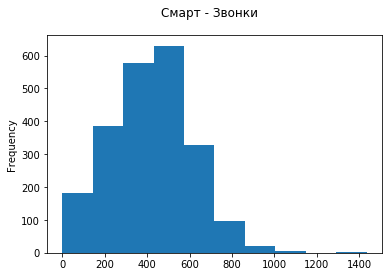

In [59]:
df[df['tariff'] == 'smart']['month_calls_duration'].plot(kind='hist', bins=10)
plt.suptitle('Смарт - Звонки')

Text(0.5, 0.98, 'Ультра - Звонки')

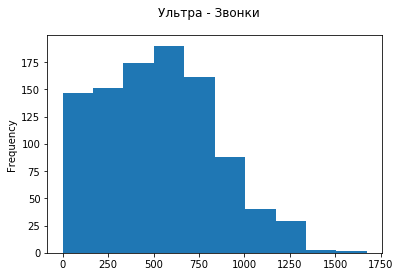

In [60]:
df[df['tariff'] == 'ultra']['month_calls_duration'].plot(kind='hist', bins=10)
plt.suptitle('Ультра - Звонки')

Видим что на тарифе смарт пользователи почти в плотную приближаются к установленной границе, а вот в тарифе ультима - пользователи не успевают проговорить 3000 минут (что мы видели в таблице общей прибыли)

### SMS

Text(0.5, 1.0, 'Смарт - СМС')

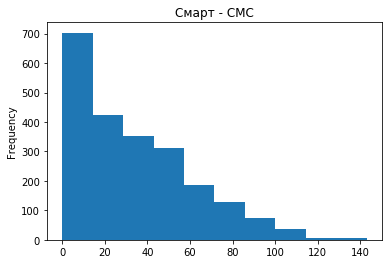

In [61]:
df[df['tariff'] == 'smart']['sms_total_in_month'].plot(kind='hist', bins=10)
plt.title('Смарт - СМС')

Text(0.5, 1.0, 'Ультра - СМС')

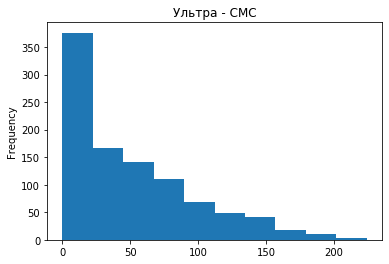

In [62]:
df[df['tariff'] == 'ultra']['sms_total_in_month'].plot(kind='hist', bins=10)
plt.title('Ультра - СМС')

СМС в смарте еще приносят прибыль, в ультре - нет (как мы видели в таблице общей прибыли)

### Интернет

Text(0.5, 1.0, 'Смарт - интернет')

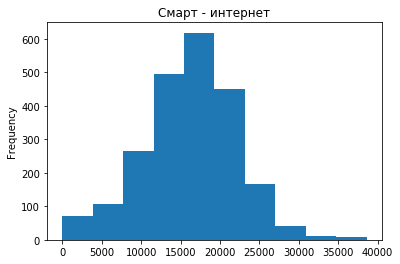

In [63]:
df[df['tariff'] == 'smart']['mb_total_in_month'].plot(kind='hist', bins=10)
plt.title('Смарт - интернет')

Text(0.5, 1.0, 'Ультра - интернет')

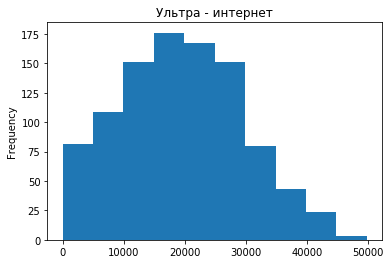

In [64]:
df[df['tariff'] == 'ultra']['mb_total_in_month'].plot(kind='hist', bins=10)
plt.title('Ультра - интернет')

а вот интернет востребован в обоих тарифах

In [65]:
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,...,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_paid,messages_paid,mg_paid,profit
0,1000,5,159.0,17.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950
1,1000,6,172.0,28.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950
2,1000,7,340.0,41.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950
3,1000,8,408.0,42.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950
4,1000,9,466.0,46.0,57.0,14581.0,52,NaT,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0,0,0,1950


Среднее, дисперсия, стандартное отклонение для прибыли и отдельно по тарифам 

In [66]:
df.pivot_table(index = ['tariff'], values = ['profit','calls_total_in_month','sms_total_in_month', 'mb_total_in_month'], aggfunc=['mean', 'var', 'std'])

mean                                                    \
       calls_total_in_month mb_total_in_month       profit sms_total_in_month   
tariff                                                                          
smart             46.947510      16229.188425  1233.057873          33.384029   
ultra             59.236548      19486.901523  2060.462944          49.363452   

                        var                                   \
       calls_total_in_month mb_total_in_month         profit   
tariff                                                         
smart            442.646705      3.454591e+07  620225.603023   
ultra           1264.707199      1.019356e+08  126869.448067   

                                           std                                \
       sms_total_in_month calls_total_in_month mb_total_in_month      profit   
tariff                                                                         
smart          796.812958            21.039171       5877.576978  787.544032   
ultra         2285.266143            35.562722      10096.317202  356.187378   

                           
       sms_total_in_month  
tariff                     
smart           28.227876  
ultra           47.804457

1. распределение по всем графикам нормальное 
2. Везде распределение Пуассона

### 4. Проверка гипотез

#### средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

нулевая гипотеза - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
альтернативная - Средняя выручка пользователей тарифов «Ультра» и «Смарт» НЕ различается

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind

In [67]:
from scipy import stats as st

smart = sum_smart['profit']
ultra = sum_ultra['profit']

print('cреднее Smart: ',pd.Series(smart).mean())
print('cреднее Ultra: ',pd.Series(ultra).mean())
alpha = .05

results = st.ttest_ind(
    smart, 
    ultra)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cреднее Smart:  1233.0578734858682
cреднее Ultra:  2060.4629441624365
p-значение: 8.2203157605818e-191
Отвергаем нулевую гипотезу


Видим что средние значения сильно различаются, лидирует тариф ультра, даже несмотря на то что доходы сверх тарифа больше у смарта 

### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

нулевая гипотеза - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
альтернативная - Средняя выручка пользователей из Москвы не различается от выручки пользователей из других регионов

список пользователей из москвы

In [68]:
moscow_tariff = df[(df['city'] == 'Москва')]

список пользователей из регионов

In [69]:
region_tariff = df[(df['city'] != 'Москва')]

In [70]:
from scipy import stats as st
import numpy as np

moscow = moscow_tariff['profit']
region = region_tariff['profit']

print('Выручка по Москве: ',pd.Series(moscow).mean())
print('Выручка с других регионов: ',pd.Series(region).mean())
alpha = 0.05

results = st.ttest_ind(
    moscow, 
    region) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Выручка по Москве:  1507.0671031096563
Выручка с других регионов:  1481.8378793699578
p-значение: 0.4741107329003996
Не получилось отвергнуть нулевую гипотезу


Можем сказать что практически не отличается выручка по Москве и по регионам

проведем те же манипуляции отдельно для тарифа смарт и ультра

### смарт

In [71]:
moscow_tariff_smart = df[(df['city'] == 'Москва') & (df['tariff'] == 'smart')]

In [72]:
region_tariff_smart = df[(df['city'] != 'Москва') & (df['tariff'] == 'smart')]

In [73]:
from scipy import stats as st
import numpy as np

moscow_tariff_smart = moscow_tariff_smart['profit'].var()
region_tariff_smart = region_tariff_smart['profit'].var()
print(moscow_tariff_smart)
print(region_tariff_smart)

print('cреднее до: ',pd.Series(moscow).mean())
print('cреднее после: ',pd.Series(region).mean())
alpha = 0.05

results = st.ttest_ind(
    moscow, 
    region,
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

516906.4954242648
641514.5834112465
cреднее до:  1507.0671031096563
cреднее после:  1481.8378793699578
p-значение: 0.4546446281204245
Не получилось отвергнуть нулевую гипотезу


### Ультра

In [74]:
moscow_tariff_ultra = df[(df['city'] == 'Москва') & (df['tariff'] == 'ultra')]

In [75]:
region_tariff_ultra = df[(df['city'] != 'Москва') & (df['tariff'] == 'ultra')]

In [76]:
from scipy import stats as st
import numpy as np

print('Выручка по Москве тарифа Ultra: ',pd.Series(moscow).mean())
print('Выручка с других регионов тарифа Ultra: ',pd.Series(region).mean())
moscow_var = region_tariff_ultra['profit'].var()
region_var = moscow_tariff_ultra['profit'].var()
alpha = 0.05

results = st.ttest_ind(
    moscow, 
    region,
    equal_var = False)
print(moscow_var)
print(region_var)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Выручка по Москве тарифа Ultra:  1507.0671031096563
Выручка с других регионов тарифа Ultra:  1481.8378793699578
132251.9549251092
109185.50892857143
p-значение: 0.4546446281204245
Не получилось отвергнуть нулевую гипотезу


Вывод: Мы выяснили что прибыль в 2х рассматриваемых тарифах сильно отличается, доход сверх тарифа в смарте выше, но средняя выручка по доходу ультима больше. А также выяснили что различий между регионами и Москвой практически нет


### 5. Общие выводы с анализа перспективного тарифа для телеком компании

1. СМС в тарифе Ультра остаются с большим запасом, в Смарте пользователи немного выходят из лимита

2. То же самое можно сказать и о звонках

3. Самый прибыльный сегмент - интернет

4. Интренетом охотно пользуются в 2х тарифах

5. Исходя из того что переплата больше в тарифе смарт, в нем может произойти отток пользователей

6. Несмотря на то что тариф Смарт приносит больше дополнительной прибыли, общая прибыль у тарифа Ультима - выше 

7. В Москве и регионах значимых отличий нет, то же можно сказать о сравнение тарифов в Москве и регионах 